# An Analysis of Magic: The Gathering's Creatures
Welcome to Magic: The Gathering, a trading card game produced by Wizards of the Coast where each player pretends to be a wizard casting spells and summoning creatures to reduce their opponent's life points from 20 to 0. This game has been out since 1993, and has changed dramatically since then, with the game increasing in power level and complexity over its 30 years of existence. 

VOCABULARY:
- mana / color
- set
- keyword
- type

Here we import all necessary modules for the project.

In [1]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import re
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression

The data we will use is from [scryfall](https://scryfall.com/), a community-ran magic the gathering site. Scryfall's data is often more reliable and accurate than the data that Wizards produces, and it is also freely available for download through their API. This data contains every single card in Magic's history that was printed in English - 78,242 card objects. However, many of these objects are extraneous and would hurt our data analysis. For the next section, I will prune down these cards to exclude reprinted cards, illegal cards, joke cards, and many other types of cards that have been created over the years.

In [2]:
URL = "https://data.scryfall.io/default-cards/default-cards-20221212220657.json"
full_scryfall_df = pd.DataFrame(json.loads(requests.get(URL).text))
full_scryfall_df.head()

,object,id,oracle_id,multiverse_ids,mtgo_id,mtgo_foil_id,tcgplayer_id,cardmarket_id,name,lang,...,tcgplayer_etched_id,attraction_lights,color_indicator,life_modifier,hand_modifier,printed_type_line,printed_text,content_warning,flavor_name,variation_of
0,card,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,[109722],25527.0,25528.0,14240.0,13850.0,Fury Sliver,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,card,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,[189637],34586.0,34587.0,33347.0,21851.0,Kor Outfitter,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,card,0000a54c-a511-4925-92dc-01b937f9afad,dc4e2134-f0c2-49aa-9ea3-ebf83af1445c,[],NaN,NaN,98659.0,NaN,Spirit,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,card,0000cd57-91fe-411f-b798-646e965eec37,9f0d82ae-38bf-45d8-8cda-982b6ead1d72,[435231],65170.0,65171.0,145764.0,301766.0,Siren Lookout,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,card,00012bd8-ed68-4978-a22d-f450c8a6e048,5aa12aff-db3c-4be5-822b-3afdf536b33e,[1278],NaN,NaN,1623.0,5664.0,Web,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This dataframe also comes with 84 columns, many of which we do not need. I will remove all columns except for the useful ones in determining a card's qualities, and in determining whether we want to analyze the card or not.

In [3]:
df = full_scryfall_df[['name',                       # the name of the card - not technically necessary but helpful for debugging
                       'mana_cost',                  # what type of mana the card costs to summon
                       'cmc',                        # how much mana the card costs
                       'type_line',                  # the type of the card (creature, sorcery, etc)
                       'oracle_text',                # what the card does
                       'power', 'toughness',         # the strength of the card if it's a creature
                       'colors', 'color_identity',   # more info on what type of mana the card costs
                       'keywords',                   # the keywords on the card (more on this later)
                       'set', 'released_at',         # when the card was released
                       'rarity',                     # how much the card was printed
                       'games',                      # games tells if it is legal online or in paper (we exclude online-only cards)
                       'legalities']]                # which formats the card is legal in

First, we will remove all cards that are in there multiple times (e.g. they were printed in multiple sets). Wizards does this sometimes to bring back fan favorite cards or to have some basic cards that always work well. 

In [4]:
df = df.sort_values(by=['released_at', 'name'])
df = df.drop_duplicates(subset=['name'])

Next, we will remove online-only cards. Wizards of the Coast released a program called Magic Arena, and to promote it they released cards that were only legal for that program. However, these cards were not created with the balance of the paper format in mind, and reference random effects and things only possible online. Therefore, I am excluding them from this analysis.

In [5]:
df = df[df['games'].apply(lambda i: 'paper' in i)]

Some cards are illegal to play for power-level reasons (too strong for the format); however, we can still analyze these. The "not legal" designation means cards that are literally unplayable: they are printed alongside magic cards, but just say promotional text or act as other game pieces. Tokens are one such piece; some cards create tokens, but you can't put the actual token cards in your deck. However, Scryfall treats all of these as "card objects" and puts them in.

In [6]:
def legal(legalities):
    v = legalities.values()
    if len(set(v)) == 1 and "not_legal" in v:
        return False
    return True

df = df[df['legalities'].apply(legal)]
df = df[~df["type_line"].str.contains("Token", na=False)] # remove tokens

Finally, some cards were designed as jokes by the Wizards designers in sets called "unsets". These cards, like the online cards, aren't tuned for interacting with any other cards, and so I will exclude them from this dataset.

In [7]:
unsets = ['unglued', 'unhinged', 'unstable', 'unsanctioned', 'unfinity']
sets = json.loads(requests.get("https://api.scryfall.com/sets").text)
for s in sets["data"]:
    if s['name'].lower() in unsets:
        df = df[~df["set"].str.contains(s['code'])]

In [8]:
# just vanilla creatures
vanilla_df = df[df["oracle_text"] == ""]
vanilla_df = vanilla_df[vanilla_df["type_line"].str.contains("Creature")]

for i in ['cmc', 'power', 'toughness']:
    vanilla_df[i] = vanilla_df[i].apply(int)

vanilla_df.head()

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities
58740,Craw Wurm,{4}{G}{G},6,Creature — Wurm,,6,4,[G],[G],[],lea,1993-08-05,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal..."
54563,Earth Elemental,{3}{R}{R},5,Creature — Elemental,,4,5,[R],[R],[],lea,1993-08-05,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal..."
66828,Fire Elemental,{3}{R}{R},5,Creature — Elemental,,5,4,[R],[R],[],lea,1993-08-05,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal..."
35350,Gray Ogre,{2}{R},3,Creature — Ogre,,2,2,[R],[R],[],lea,1993-08-05,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal..."
63158,Grizzly Bears,{1}{G},2,Creature — Bear,,2,2,[G],[G],[],lea,1993-08-05,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal..."


<AxesSubplot: xlabel='cmc'>

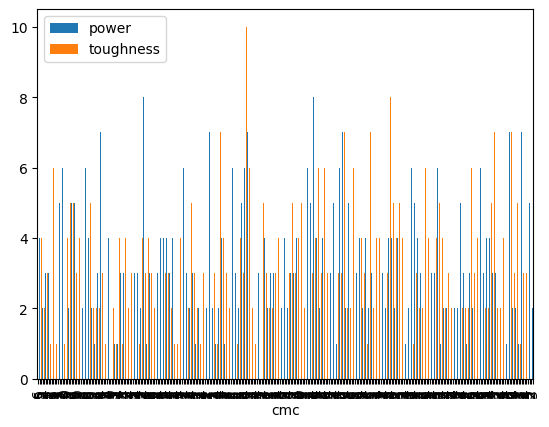

In [9]:
vanilla_df.plot.bar('cmc')

In [10]:
x = set()
for i, row in df.iterrows():
    if row['set'] not in ['afr', '40k', 'clb', 'sld']:
        x = x.union(row['keywords'])
    else:
        # ignore multimodal keywords
        x = x.union([i for i in row['keywords'] if ' ' not in i])
keyword_soup = ' '.join(x).lower()
print(keyword_soup)

boast ward daybound training conjure megamorph legendary landwalk partner with exert horsemanship mill splice hexproof partner stowage prowess embalm kinship surveil champion overload prototype rally protector totem armor delirium council's dilemma spectacle compleated polymorphine magecraft flash cumulative upkeep soulshift support bolster mountaincycling addendum casualty shroud shadow assemble detain modular titanic demonstrate swampwalk hidden agenda improvise lifelink reinforce islandwalk persist delve flanking reach retrace converge nightbound prowl transfigure fuse devoid battalion vigilance cascade disturb enthralling performance foretell phaeron escape buyback mama's coming hexproof from devour replicate berzerker crew hadoken encore trample jump-start spell mastery venture into the dungeon bloodthirst plainswalk multikicker blitz ferocious split second ascend storm intimidate wither monstrosity strive shieldwall afterlife reconfigure rampage fear typecycling first strike hell

In [12]:
removes = [r'\(.*?\)', r'\{.*?\}', r'—[^ ][^\n]*', r'(P|p)rotection(?! F)[^\n]*', r'\d*', r'Prototype[^\n]*']
#r'—[^{][^T][^\n]*', 
# todo protection, ward, a lot of stuff actually

def extract_ability_text(row):
    text = row['oracle_text']

    if text is np.nan:
        return ''
    
    for r in removes:
        text = re.sub(r, '', text)
    text = text.replace(',', '').replace(';', '')
    text = text.lower()
    text = text.strip()

    return text

def is_french_vanilla(row):
    text = row['oracle_text']
    
    if text == '': 
        return True # is just vanilla
    
    if text is np.nan:
        return False # is not valid
    
    text = extract_ability_text(row)

    for i in text.split():
        if i not in keyword_soup:
            return False

    return True

french_vanilla_df = df[df["type_line"].str.contains("Creature", na=False)] # for now just creatures
french_vanilla_df = french_vanilla_df.sort_values(by=['name'])
french_vanilla_df['is_french_vanilla'] = french_vanilla_df.apply(is_french_vanilla, axis=1)
french_vanilla_df = french_vanilla_df[french_vanilla_df['is_french_vanilla']]

french_vanilla_df = french_vanilla_df.sort_values(by=['name'])

french_vanilla_df


,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,is_french_vanilla
34736,Abbey Gargoyles,{2}{W}{W}{W},5.0,Creature — Gargoyle,"Flying, protection from red",3,4,[W],[W],"[Flying, Protection]",hml,1995-10-01,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",True
58613,Abbey Griffin,{3}{W},4.0,Creature — Griffin,"Flying, vigilance",2,2,[W],[W],"[Flying, Vigilance]",isd,2011-09-30,common,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",True
42882,Aboroth,{4}{G}{G},6.0,Creature — Elemental,Cumulative upkeep—Put a -1/-1 counter on Aboro...,9,9,[G],[G],[Cumulative upkeep],wth,1997-06-09,rare,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",True
8498,Abzan Guide,{3}{W}{B}{G},6.0,Creature — Human Warrior,Lifelink (Damage dealt by this creature also c...,4,4,"[B, G, W]","[B, G, W]","[Lifelink, Morph]",ktk,2014-09-26,common,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",True
29975,Accomplished Automaton,{7},7.0,Artifact Creature — Construct,Fabricate 1 (When this creature enters the bat...,5,7,[],[],[Fabricate],kld,2016-09-30,common,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52344,Zodiac Tiger,{2}{G}{G},4.0,Creature — Cat,Forestwalk (This creature can't be blocked as ...,3,4,[G],[G],"[Landwalk, Forestwalk]",ptk,1999-07-06,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",True
54912,Zombie Brute,{6}{B},7.0,Creature — Zombie,Amplify 1 (As this creature enters the battlef...,5,4,[B],[B],"[Amplify, Trample]",lgn,2003-02-03,uncommon,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",True
77725,Zombie Cutthroat,{3}{B}{B},5.0,Creature — Zombie,Morph—Pay 5 life. (You may cast this card face...,3,4,[B],[B],[Morph],scg,2003-05-26,common,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",True
62508,Zombie Goliath,{4}{B},5.0,Creature — Zombie Giant,,4,3,[B],[B],[],m10,2009-07-17,common,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",True


In [13]:
french_vanilla_df[french_vanilla_df['rarity'] == 'mythic']

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,is_french_vanilla
43836,Apex Devastator,{8}{G}{G},10.0,Creature — Chimera Hydra,"Cascade, cascade, cascade, cascade (When you c...",10,10,[G],[G],[Cascade],cmr,2020-11-20,mythic,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",True
31650,Baneslayer Angel,{3}{W}{W},5.0,Creature — Angel,"Flying, first strike, lifelink, protection fro...",5,5,[W],[W],"[Flying, Lifelink, First strike, Protection]",m10,2009-07-17,mythic,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",True
55601,Furyborn Hellkite,{4}{R}{R}{R},7.0,Creature — Dragon,Bloodthirst 6 (If an opponent was dealt damage...,6,6,[R],[R],"[Flying, Bloodthirst]",m12,2011-07-15,mythic,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",True
75215,Impervious Greatwurm,{7}{G}{G}{G},10.0,Creature — Wurm,Convoke (Your creatures can help cast this spe...,16,16,[G],[G],"[Indestructible, Convoke]",grn,2018-10-05,mythic,"[arena, paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",True
61295,Sphinx of the Steel Wind,{5}{W}{U}{B},8.0,Artifact Creature — Sphinx,"Flying, first strike, vigilance, lifelink, pro...",6,6,"[B, U, W]","[B, U, W]","[Flying, Lifelink, Vigilance, First strike, Pr...",arb,2009-04-30,mythic,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",True
5986,Vorapede,{2}{G}{G}{G},5.0,Creature — Insect,"Vigilance, trample\nUndying (When this creatur...",5,4,[G],[G],"[Undying, Vigilance, Trample]",dka,2012-02-03,mythic,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",True


In [ ]:
# todo organize code
alpha_release_date = dt.datetime(1993, 8, 5)
# ignore type line for now
data_df = french_vanilla_df.drop(columns=['name', 'mana_cost', 'type_line', 'oracle_text', 'color_identity', 'set', 'is_french_vanilla', 'games', 'legalities'])
data_df['cmc'] = data_df['cmc'].apply(int)
data_df['power'] = data_df['power'].apply(int)
data_df['toughness'] = data_df['toughness'].apply(int)
data_df['released_at'] = data_df['released_at'].apply(lambda i: (dt.datetime.strptime(i, '%Y-%m-%d').year - alpha_release_date.year))
data_df


In [ ]:
def dummy_list(data_df, one_hot_df, column):
    x = set(data_df.explode(column)[column].values)
    x.remove(np.nan)
    
    for i in x:
        one_hot_df[f'{column}_{i}'] = data_df[column].apply(lambda j: int(i in j))
    

one_hot_df = pd.get_dummies(data_df.drop(columns=['colors', 'keywords']))
dummy_list(data_df, one_hot_df, 'colors')
dummy_list(data_df, one_hot_df, 'keywords')
one_hot_df

In [ ]:
# make new dummy matrices for interaction terms
X = one_hot_df.drop(columns=['cmc', 'rarity_common'])
y = one_hot_df['cmc']

# make new linear regression
reg2 = LinearRegression().fit(X, y)

# print all coefficients
for name, coef in zip(X.columns, reg2.coef_):
    print(f"{name} Coefficient: {coef}")
print("Intercept:", reg2.intercept_)


In [21]:
activated_abilities_df = df[df["type_line"].str.contains("Creature", na=False)]

def extract_activated_abilities(row):
    text = row['oracle_text']
    
    if text == '': 
        return [] # is just vanilla
    
    if text is np.nan:
        return [] # is not valid
    ret = []
    for i in text.split("\n"):
        if ":" in i:
            ret.append(i.replace(row['name'], 'CARDNAME'))
    return ret
    
import collections
count = collections.defaultdict(int)
for i, row in activated_abilities_df.iterrows():
    ret = extract_activated_abilities(row)
    for j in ret:
        count[j] += 1

for k, v in count.items():
    if v > 10:
        print(k, v)
        input()

{T}: Add one mana of any color. 26

{B}: CARDNAME gets +1/+1 until end of turn. 24

{T}: Add {G}. 25

{T}: CARDNAME deals 1 damage to any target. 23

{T}: Prevent the next 1 damage that would be dealt to any target this turn. 15

{B}: Regenerate CARDNAME. 29

{R}: CARDNAME gets +1/+0 until end of turn. 48

{G}: Regenerate CARDNAME. 12

{W}: CARDNAME gets +0/+1 until end of turn. 16

Remove three spore counters from CARDNAME: Create a 1/1 green Saproling creature token. 13

{1}{G}: Regenerate CARDNAME. 12

{1}{B}: Regenerate CARDNAME. 17

{1}{R}: CARDNAME gets +1/+0 until end of turn. 13

{W}, {T}: Tap target creature. 17

Cycling {2} ({2}, Discard this card: Draw a card.) 33



In [ ]:
# import spacy
# nlp = spacy.load("en_core_web_sm")
creature_df = df[df["type_line"].str.contains("Creature", na=False)]
creature_df["mana_cost_spaced"] = creature_df["mana_cost"].apply(lambda i: i.replace("}{", "} {") if isinstance(i, str) else i)

tokens = {'': 0}
num_tokens = 1

replaces = [
      [",", " {comma} "],
      [":", " {colon} "],
      [".", " {period} "],
      [";", " {semicolon} "],
    ["\n", " {newline} "],
      ["}{", "} {"]]

def get_data(row):
    t = row["oracle_text"]
    if t is not np.nan:
        t = t.replace(row["name"], "{CARDNAME}")
        for i, j in replaces:
            t = t.replace(i, j)
    return [t]
#     return [row["name"], row["mana_cost_spaced"], row["type_line"], row["power"], row["toughness"], row["oracle_text"]]

def process(text):
    # remove reminder text & ,.
    return re.sub(removes[0], '', text).lower().replace(',', '').replace('.', '')

for i, row in creature_df.iterrows():
    for data in get_data(row):
#         doc = row["oracle_text"] # nlp().tokens took too long but im still considering it
        if not isinstance(data, str):
            continue # split cards have no orcale text
        data = process(data)

        for token in data.split():
            if token not in tokens:
                tokens[token] = num_tokens
                num_tokens += 1

creature_df.head()


In [ ]:
print(num_tokens)
tokens_list = list(tokens.keys())

In [ ]:
def encode(text):
    if text is np.nan:
        return []
    t = process(text).split()
    return [tokens[i] for i in t]

def encode_row(row):
    data = get_data(row)
    # todo pad mana cost & type line
    out = []
    for i in data:
        out.extend(encode(i))

    return out

def decode(encoded):
    s = " ".join(tokens_list[i] for i in encoded)
    for i, j in replaces[:-1]:
        s = s.replace(j, i + " ")
        s = s.replace(j.strip(), i + " ")
    return s

name = "Pixie Illusionist"
t = creature_df[creature_df["name"] == name].iloc[0]
print(t)
print(encode_row(t))
print(decode(encode_row(t)))

In [ ]:
creature_df["encoded"] = creature_df.apply(encode_row, axis=1)
creature_df["encoded_length"] = creature_df["encoded"].apply(len)

In [ ]:
creature_df = creature_df[creature_df["encoded_length"] < 20]

In [ ]:
total_words = max(creature_df["encoded_length"])
largest_encode = max(creature_df["encoded_length"])
creature_df[creature_df["encoded_length"] == largest_encode]

In [ ]:
input_sequences = []
for seq in creature_df["encoded"]:
#     input_sequences.append(seq)
    for i in range(1, len(seq)):
        input_sequences.append(seq[:i + 1])

In [ ]:
import tensorflow.keras.utils as ku
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
total_words = num_tokens
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import tensorflow as tf

# https://github.com/nicknochnack/GANBasics/blob/main/FashionGAN-Tutorial.ipynb
# https://towardsdatascience.com/training-neural-networks-to-create-text-like-a-human-23bfdc23c28

model = Sequential()
model.add(Embedding(total_words, 240, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
max(input_sequences[:,-1])

In [ ]:
len(label[0])
total_words

In [ ]:
import os
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=1963)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()
history = model.fit(predictors, label, epochs=300, verbose=1, callbacks=[cp_callback, callbacks])
 

In [ ]:
model.load_weights("training_3/cp-0003.ckpt")

In [ ]:
len(input_sequences)

In [ ]:
thingy = [tokens["{g}"]]
for i in range(40):
    X = pad_sequences([thingy], maxlen=max_sequence_len - 1, padding='pre')
    thingy.append(np.argmax(model.predict(X)))

print(thingy)
print(decode(thingy))

In [ ]:
import torch
from torch import nn
import math

In [ ]:
eighteen_df = creature_df[creature_df["encoded_length"] == 18]
largest_encode = 18

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(largest_encode, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(largest_encode, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, largest_encode),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
train_data_length = len(eighteen_df.index) - (len(eighteen_df.index) % 32)
train_data = torch.tensor(pad_sequences(eighteen_df["encoded"].values[:train_data_length], maxlen=largest_encode, padding="post"))
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
print(train_set[300])


In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [ ]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [ ]:
discriminator = Discriminator()
generator = Generator()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
import tqdm
for epoch in tqdm.trange(num_epochs):
    for n, (real_samples, _) in list(enumerate(train_loader)):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, largest_encode))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, largest_encode))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()
    
        # Show loss
#         if epoch % 10 == 0 and n == batch_size - 1:
#         print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
#         print(f"Epoch: {epoch} Loss G.: {loss_generator}")
        
#             latent_space_samples = torch.randn(100, 2)
#             generated_samples = generator(latent_space_samples)
#             generated_samples = generated_samples.detach()
#             plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
#             plt.show()
#             input()

In [ ]:
latent_space_samples = torch.randn(1, largest_encode)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

print(decode(list(map(int, list(generated_samples[0])))))
generated_samples

In [ ]:
plt.hist(creature_df["encoded_length"])